In [1]:
# load model
# https://github.com/ContextualAI/gritlm
from gritlm import GritLM
model = GritLM("GritLM/GritLM-7B", torch_dtype="auto", mode="embedding")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Created GritLM: torch.bfloat16 dtype, mean pool, embedding mode, bbcc attn


In [2]:
# embedding test
from scipy.spatial.distance import cosine
def get_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)

texts = ["machine learning", "deep learning"]
results = model.encode(texts)
similarity = get_similarity(results[0], results[1])
print(results.shape, similarity)

(2, 4096) 0.9033003987849012


In [3]:
# load text
with open("text.txt", "r") as f:
    text = f.read()
text = text.replace("\n", " ")
len(text), text[:100]

(9197,
 'The task of building general agents that perform well over a wide range of tasks has been an importa')

In [4]:
# split text into sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
children = sent_tokenize(text)
len(children), children[:2]

[nltk_data] Downloading package punkt to /home/tobias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(45,
 ['The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception.',
  'The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark.'])

In [5]:
# generate embedding for all sentences
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass

@dataclass
class Sentence:
    text: str
    embedding: np.ndarray

results = []
for sentence in tqdm(children):
    embedding = model.encode(sentence)
    results.append(Sentence(sentence, embedding))

results[0].text, results[0].embedding.shape, results[0].embedding

100%|██████████| 45/45 [00:01<00:00, 36.67it/s]


('The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception.',
 (4096,),
 array([-0.01639684, -0.01371807, -0.04035494, ...,  0.00850398,
         0.02411986, -0.03331469], dtype=float32))

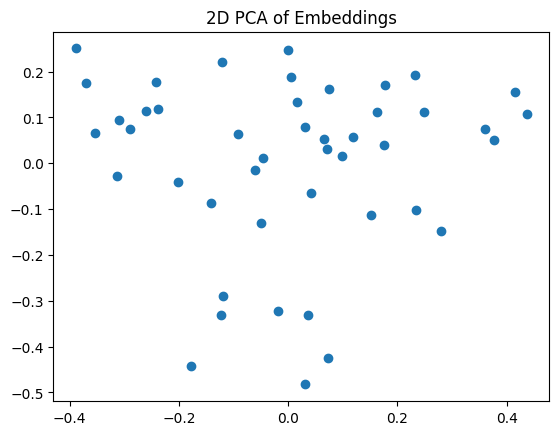

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

embeddings = np.array([sentence.embedding for sentence in results])
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title('2D PCA of Embeddings')
plt.show()

In [8]:
# calculate rolling embeddings
class RollingEmbedding:
    def __init__(self):
        self.children:list[Sentence] = []
        self.sentence = None
    
    def add_sentence(self, sentence:Sentence):
        self.children.append(sentence)
        self.update()
    
    def update(self):
        assert len(self.children) > 0
        if len(self.children) == 1:
            self.sentence = self.children[0]
            return

        text = " ".join([sentence.text for sentence in self.children])
        embedding = model.encode(text)
        self.sentence = Sentence(text, embedding)

    def remove_last(self):
        self.children.pop()
        self.update()

    def __repr__(self):
        return f"RollingEmbedding({len(self.children)}, {self.sentence.text}, {self.sentence.embedding})"


rolling_embeddings = []
working = RollingEmbedding()
for sentence in tqdm(results):
    working.add_sentence(sentence)
    if len(working.children) == 1:
        continue

    similarity = get_similarity(working.sentence.embedding, sentence.embedding)
    print(similarity)
    if similarity < 0.5:
        working.remove_last()
        rolling_embeddings.append(working.sentence)
        working = RollingEmbedding()

# add last working
if len(working.children) > 0:
    rolling_embeddings.append(working.sentence)

print()
print(len(rolling_embeddings))

for re in rolling_embeddings:
    print(f"- {re.embedding[:3]}... {re.text}")


 13%|█▎        | 6/45 [00:00<00:02, 14.84it/s]

0.7845113405876567
0.8151298540985469
0.7454590797424316
0.6825941015836073
0.5652437210083008
0.663315872750779


 29%|██▉       | 13/45 [00:00<00:01, 21.90it/s]

0.4238765401619514
0.8054183241475642
0.8413293361663818
0.6819134950637817
0.5723955121511872


 36%|███▌      | 16/45 [00:00<00:01, 21.42it/s]

0.6503770128454359
0.7052948299226076
0.6764788031578064
0.574582576751709


 42%|████▏     | 19/45 [00:01<00:01, 17.90it/s]

0.6297359907941874
0.4823082983493805
0.8472857636766853
0.8100800046396291


 53%|█████▎    | 24/45 [00:01<00:00, 21.94it/s]

0.7743875019069765
0.3287704689043487
0.9509372769669032
0.7708441751692204
0.5409128665924072


 71%|███████   | 32/45 [00:01<00:00, 24.35it/s]

0.6024941385535642
0.6963032122019832
0.4342187772458429
0.8692535161972046


 80%|████████  | 36/45 [00:01<00:00, 25.29it/s]

0.797067689720852
0.7568949009838772
0.7332350015640259
0.7333276490368742
0.4558632943548744


 93%|█████████▎| 42/45 [00:01<00:00, 23.62it/s]

0.8535067017666518
0.8545981645584106
0.7043086920060566
0.6821382655625012


100%|██████████| 45/45 [00:02<00:00, 21.05it/s]

0.45844178896448806

7
- [-0.02077962 -0.02182585 -0.03467401]... The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception. The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark. Agent57 was the first agent to surpass the human benchmark on all 57 games, but this came at the cost of poor data-efficiency, requiring nearly 80 billion frames of experience to achieve. Taking Agent57 as a starting point, we employ a diverse set of strategies to achieve a 200-fold reduction of experience needed to outperform the human baseline. We investigate a range of instabilities and bottlenecks we encountered while reducing the data regime, and propose effective solutions to build a more robust and efficient agent. We also demonstrate competitive performance with high-p